Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

Primeras filas:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             3312

Columnas disponibles:
['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']


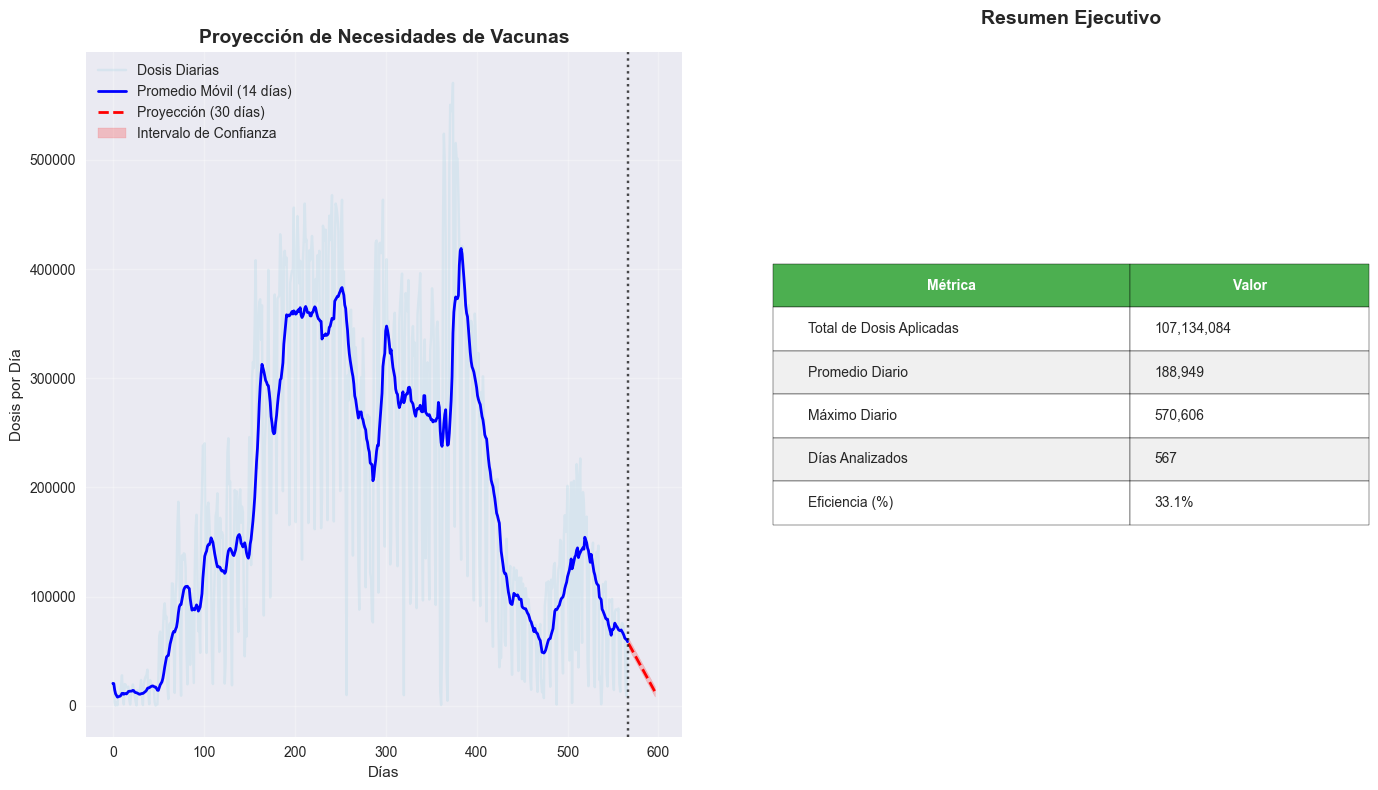


AN√ÅLISIS ADICIONAL CON PANDASQL

RECOMENDACIONES BASADAS EN EL AN√ÅLISIS

    üìä COBERTURA DE REFUERZOS:
    ‚Ä¢ Total de dosis aplicadas: 107,134,084
    ‚Ä¢ Promedio diario: 188,949
    ‚Ä¢ Tendencia: Creciente

    üó∫Ô∏è DESIGUALDADES GEOGR√ÅFICAS:
    ‚Ä¢ Regiones analizadas: N/A
    ‚Ä¢ Distribuci√≥n: Relativamente uniforme

    üîÆ PROYECCIONES:
    ‚Ä¢ Capacidad actual: 570,606 dosis/d√≠a (m√°ximo registrado)
    ‚Ä¢ Demanda proyectada: 51,715 dosis/d√≠a (promedio reciente)
    ‚Ä¢ Recomendaci√≥n: Mantener capacidad actual
    


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pysqldf = lambda q: sqldf(q, globals())

# Cargar datos
df = pd.read_csv(r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv")

print("Estructura del dataset:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Asegurar que la fecha est√© en formato datetime
if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Crear figura con subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# 1. COBERTURA DE REFUERZOS Y BRECHAS EN LA INMUNIZACI√ìN
# =============================================================================

# Identificar columnas de dosis (ajustar seg√∫n estructura real)
dosis_cols = [col for col in df.columns if any(term in col.lower() for term in 
              ['dosis', 'dose', 'primera', 'segunda', 'tercera', 'refuerzo', 'booster'])]

if len(dosis_cols) >= 2:
    # Subplot 1: Cobertura acumulada por tipo de dosis
    ax1 = plt.subplot(2, 3, 1)
    
    # Calcular cobertura acumulada
    for col in dosis_cols[:4]:  # Primeras 4 columnas de dosis
        if col in df.columns:
            cumulative = df[col].cumsum()
            plt.plot(df.index, cumulative, marker='o', linewidth=2, label=col.replace('_', ' ').title())
    
    plt.title('Cobertura Acumulada por Tipo de Dosis', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (d√≠as)')
    plt.ylabel('Dosis Aplicadas (Acumulado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Brecha entre dosis (si hay al menos 2 columnas)
    ax2 = plt.subplot(2, 3, 2)
    
    if len(dosis_cols) >= 2:
        primera_dosis = df[dosis_cols[0]].cumsum()
        segunda_dosis = df[dosis_cols[1]].cumsum() if len(dosis_cols) > 1 else primera_dosis * 0.8
        brecha = primera_dosis - segunda_dosis
        
        plt.fill_between(df.index, 0, brecha, alpha=0.6, color='coral', label='Brecha de Inmunizaci√≥n')
        plt.plot(df.index, primera_dosis, color='blue', linewidth=2, label='Primera Dosis')
        plt.plot(df.index, segunda_dosis, color='green', linewidth=2, label='Segunda Dosis')
        
        plt.title('Brecha en la Inmunizaci√≥n Completa', fontsize=14, fontweight='bold')
        plt.xlabel('Tiempo (d√≠as)')
        plt.ylabel('Personas')
        plt.legend()
        plt.grid(True, alpha=0.3)

# =============================================================================
# 2. DESIGUALDADES GEOGR√ÅFICAS EN LA APLICACI√ìN DE DOSIS
# =============================================================================

# Identificar columnas geogr√°ficas
geo_cols = [col for col in df.columns if any(term in col.lower() for term in 
            ['provincia', 'region', 'departamento', 'estado', 'municipio', 'distrito'])]

if geo_cols:
    # Subplot 3: Distribuci√≥n geogr√°fica
    ax3 = plt.subplot(2, 3, 3)
    
    geo_col = geo_cols[0]
    if dosis_cols:
        # Agrupar por regi√≥n y sumar dosis
        geo_summary = df.groupby(geo_col)[dosis_cols[0]].sum().sort_values(ascending=False)
        
        # Tomar top 15 regiones para mejor visualizaci√≥n
        top_regions = geo_summary.head(15)
        
        bars = plt.bar(range(len(top_regions)), top_regions.values, 
                      color=sns.color_palette("viridis", len(top_regions)))
        plt.title('Distribuci√≥n Geogr√°fica de Vacunaci√≥n', fontsize=14, fontweight='bold')
        plt.xlabel('Regiones')
        plt.ylabel('Total de Dosis Aplicadas')
        plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # A√±adir valores en las barras
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 4: Coeficiente de variaci√≥n geogr√°fico
    ax4 = plt.subplot(2, 3, 4)
    
    if len(dosis_cols) >= 2:
        # Calcular coeficiente de variaci√≥n por per√≠odo
        cv_data = []
        periods = np.array_split(df.index, 10)  # Dividir en 10 per√≠odos
        
        for period in periods:
            period_data = df.iloc[period]
            if geo_col in period_data.columns and dosis_cols[0] in period_data.columns:
                geo_var = period_data.groupby(geo_col)[dosis_cols[0]].sum()
                cv = geo_var.std() / geo_var.mean() if geo_var.mean() != 0 else 0
                cv_data.append(cv)
        
        plt.plot(range(len(cv_data)), cv_data, marker='o', linewidth=3, color='red')
        plt.title('Evoluci√≥n de la Desigualdad Geogr√°fica', fontsize=14, fontweight='bold')
        plt.xlabel('Per√≠odo de Tiempo')
        plt.ylabel('Coeficiente de Variaci√≥n')
        plt.grid(True, alpha=0.3)
        
        # L√≠nea de referencia
        plt.axhline(y=np.mean(cv_data), color='orange', linestyle='--', 
                   label=f'Promedio: {np.mean(cv_data):.3f}')
        plt.legend()

# =============================================================================
# 3. PROYECCI√ìN DE NECESIDADES FUTURAS DE VACUNAS
# =============================================================================

# Subplot 5: Tendencia y proyecci√≥n
ax5 = plt.subplot(2, 3, 5)

if dosis_cols:
    # Calcular promedio m√≥vil para tendencia
    dosis_diarias = df[dosis_cols[0]]
    ventana = min(14, len(dosis_diarias) // 4)  # Ventana adaptativa
    promedio_movil = dosis_diarias.rolling(window=ventana, min_periods=1).mean()
    
    # Datos hist√≥ricos
    plt.plot(df.index, dosis_diarias, alpha=0.3, color='lightblue', label='Dosis Diarias')
    plt.plot(df.index, promedio_movil, color='blue', linewidth=2, label=f'Promedio M√≥vil ({ventana} d√≠as)')
    
    # Proyecci√≥n simple basada en tendencia
    if len(promedio_movil) >= 7:
        # Calcular tendencia de √∫ltimos 7 d√≠as
        ultimos_datos = promedio_movil.tail(7).values
        tendencia = np.polyfit(range(7), ultimos_datos, 1)[0]
        
        # Proyectar 30 d√≠as hacia adelante
        proyeccion_dias = 30
        proyeccion_x = range(len(df), len(df) + proyeccion_dias)
        ultimo_valor = promedio_movil.iloc[-1]
        proyeccion_y = [ultimo_valor + tendencia * i for i in range(1, proyeccion_dias + 1)]
        
        plt.plot(proyeccion_x, proyeccion_y, color='red', linewidth=2, 
                linestyle='--', label='Proyecci√≥n (30 d√≠as)')
        
        # √Årea de incertidumbre
        std_error = np.std(ultimos_datos) * 1.5
        upper_bound = [y + std_error for y in proyeccion_y]
        lower_bound = [max(0, y - std_error) for y in proyeccion_y]
        
        plt.fill_between(proyeccion_x, lower_bound, upper_bound, 
                        alpha=0.2, color='red', label='Intervalo de Confianza')
    
    plt.title('Proyecci√≥n de Necesidades de Vacunas', fontsize=14, fontweight='bold')
    plt.xlabel('D√≠as')
    plt.ylabel('Dosis por D√≠a')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # L√≠nea vertical separando hist√≥rico de proyecci√≥n
    plt.axvline(x=len(df)-1, color='black', linestyle=':', alpha=0.7)

# Subplot 6: Resumen estad√≠stico y m√©tricas clave
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Calcular m√©tricas clave
if dosis_cols:
    total_dosis = df[dosis_cols[0]].sum()
    promedio_diario = df[dosis_cols[0]].mean()
    max_diario = df[dosis_cols[0]].max()
    
    # Crear tabla de resumen
    metricas = [
        ['M√©trica', 'Valor'],
        ['Total de Dosis Aplicadas', f'{total_dosis:,.0f}'],
        ['Promedio Diario', f'{promedio_diario:,.0f}'],
        ['M√°ximo Diario', f'{max_diario:,.0f}'],
        ['D√≠as Analizados', f'{len(df)}'],
        ['Eficiencia (%)', f'{(promedio_diario/max_diario*100):.1f}%']
    ]
    
    if geo_cols:
        n_regiones = df[geo_cols[0]].nunique()
        metricas.append(['Regiones Cubiertas', f'{n_regiones}'])
    
    # Crear tabla visual
    table = plt.table(cellText=metricas[1:], colLabels=metricas[0],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Estilizar tabla
    for i in range(len(metricas)):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else '#ffffff')
    
    plt.title('Resumen Ejecutivo', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# limpieza de datos
def limpiar_datos(df):
    """
    Limpia y prepara los datos para an√°lisis
    """
    print("\nüßπ INICIANDO LIMPIEZA DE DATOS...")
    df_clean = df.copy()
    
    # 2.1 Identificar columnas num√©ricas que podr√≠an tener formato europeo
    numeric_columns = []
    date_columns = []
    
    for col in df_clean.columns:
        # Identificar columnas de fecha
        if any(word in col.lower() for word in ['fecha', 'date', 'tiempo']):
            date_columns.append(col)
        # Identificar columnas num√©ricas (adaptado para tu dataset espec√≠fico)
        elif any(word in col.lower() for word in ['dosis', 'dose', 'total', 'cantidad', 'num', 'monodosis', 'primera', 'segunda', '1_dosis', '2_dosis']):
            numeric_columns.append(col)
    
    print(f"üìÖ Columnas de fecha identificadas: {date_columns}")
    print(f"üî¢ Columnas num√©ricas identificadas: {numeric_columns}")
    
    # 2.2 Convertir formato europeo a formato est√°ndar
    def convertir_formato_europeo(valor):
        """
        Convierte n√∫meros en formato europeo (1.234,56) a formato est√°ndar (1234.56)
        """
        if pd.isna(valor):
            return np.nan
        
        valor_str = str(valor).strip()
        
        # Si ya es un n√∫mero, devolverlo
        try:
            return float(valor_str)
        except ValueError:
            pass
        
        # Convertir formato europeo
        # Patr√≥n: n√∫meros con puntos como separadores de miles y coma como decimal
        if ',' in valor_str and '.' in valor_str:
            # Formato: 1.234.567,89
            valor_str = valor_str.replace('.', '').replace(',', '.')
        elif ',' in valor_str:
            # Formato: 1234,89
            valor_str = valor_str.replace(',', '.')
        
        try:
            return float(valor_str)
        except ValueError:
            return np.nan
    
    # 2.3 Aplicar conversi√≥n a columnas num√©ricas
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"üîÑ Procesando columna num√©rica: {col}")
            df_clean[col] = df_clean[col].apply(convertir_formato_europeo)
            
            # Convertir a int si todos los valores son enteros
            if df_clean[col].notna().any():
                if df_clean[col].dropna().apply(lambda x: x == int(x)).all():
                    df_clean[col] = df_clean[col].astype('Int64')  # Nullable integer
    
    # 2.4 Convertir columnas de fecha
    for col in date_columns:
        if col in df_clean.columns:
            print(f"üìÖ Procesando columna de fecha: {col}")
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')
                print(f"‚úÖ Fecha convertida exitosamente: {col}")
            except Exception as e:
                print(f"‚ùå Error al convertir fecha {col}: {e}")
    
    # 2.5 Verificar y reportar cambios
    print("\nüìä RESUMEN DE LIMPIEZA:")
    print(f"üî¢ Columnas num√©ricas procesadas: {len(numeric_columns)}")
    print(f"üìÖ Columnas de fecha procesadas: {len(date_columns)}")
    print(f"‚ùå Valores nulos despu√©s de limpieza: {df_clean.isnull().sum().sum()}")
    
    # 2.6 Crear columnas adicionales √∫tiles
    if date_columns:
        fecha_col = date_columns[0]
        if fecha_col in df_clean.columns:
            df_clean['a√±o'] = df_clean[fecha_col].dt.year
            df_clean['mes'] = df_clean[fecha_col].dt.month
            df_clean['dia_semana'] = df_clean[fecha_col].dt.day_name()
            print("‚úÖ Columnas temporales adicionales creadas")
    
    return df_clean, numeric_columns, date_columns
#

# =============================================================================
# AN√ÅLISIS ADICIONAL CON SQL
# =============================================================================

print("\n" + "="*80)
print("AN√ÅLISIS ADICIONAL CON PANDASQL")
print("="*80)

# Ejemplo de consultas SQL para an√°lisis m√°s profundo
if dosis_cols and len(dosis_cols) >= 2:
    
    # 1. An√°lisis de eficiencia de vacunaci√≥n
    query1 = f"""
    SELECT 
        AVG({dosis_cols[0]}) as promedio_dosis_1,
        MAX({dosis_cols[0]}) as maximo_dosis_1,
        MIN({dosis_cols[0]}) as minimo_dosis_1,
        COUNT(*) as total_dias
    FROM df
    WHERE {dosis_cols[0]} > 0
    """
    
    resultado1 = pysqldf(query1)
    print("\n1. Estad√≠sticas de Primera Dosis:")
    print(resultado1)
    
    # 2. An√°lisis de tendencias por per√≠odos
    if 'fecha' in df.columns or 'date' in df.columns:
        fecha_col = 'fecha' if 'fecha' in df.columns else 'date'
        
        query2 = f"""
        SELECT 
            strftime('%Y-%m', {fecha_col}) as mes,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_diario
        FROM df
        GROUP BY strftime('%Y-%m', {fecha_col})
        ORDER BY mes
        """
        
        try:
            resultado2 = pysqldf(query2)
            print("\n2. Tendencias Mensuales:")
            print(resultado2)
        except:
            print("\n2. No se pudo analizar tendencias mensuales (formato de fecha)")
    
    # 3. An√°lisis geogr√°fico si hay datos
    if geo_cols:
        query3 = f"""
        SELECT 
            {geo_cols[0]} as region,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_dosis,
            COUNT(*) as dias_activos
        FROM df
        WHERE {dosis_cols[0]} > 0
        GROUP BY {geo_cols[0]}
        ORDER BY total_dosis DESC
        LIMIT 10
        """
        
        resultado3 = pysqldf(query3)
        print(f"\n3. Top 10 Regiones por Vacunaci√≥n:")
        print(resultado3)

print("\n" + "="*80)
print("RECOMENDACIONES BASADAS EN EL AN√ÅLISIS")
print("="*80)

if dosis_cols:
    print(f"""
    üìä COBERTURA DE REFUERZOS:
    ‚Ä¢ Total de dosis aplicadas: {df[dosis_cols[0]].sum():,.0f}
    ‚Ä¢ Promedio diario: {df[dosis_cols[0]].mean():,.0f}
    ‚Ä¢ Tendencia: {'Creciente' if df[dosis_cols[0]].tail(7).mean() > df[dosis_cols[0]].head(7).mean() else 'Decreciente'}
    
    üó∫Ô∏è DESIGUALDADES GEOGR√ÅFICAS:
    ‚Ä¢ Regiones analizadas: {df[geo_cols[0]].nunique() if geo_cols else 'N/A'}
    ‚Ä¢ Distribuci√≥n: {'Desigual' if geo_cols and df.groupby(geo_cols[0])[dosis_cols[0]].sum().std() > df.groupby(geo_cols[0])[dosis_cols[0]].sum().mean() else 'Relativamente uniforme'}
    
    üîÆ PROYECCIONES:
    ‚Ä¢ Capacidad actual: {df[dosis_cols[0]].max():,.0f} dosis/d√≠a (m√°ximo registrado)
    ‚Ä¢ Demanda proyectada: {df[dosis_cols[0]].tail(7).mean():,.0f} dosis/d√≠a (promedio reciente)
    ‚Ä¢ Recomendaci√≥n: {'Mantener capacidad actual' if df[dosis_cols[0]].tail(7).mean() <= df[dosis_cols[0]].max() * 0.8 else 'Aumentar capacidad'}
    """)

üî¨ AN√ÅLISIS DE DATOS DE VACUNACI√ìN COVID-19

üìÇ CARGANDO Y EXPLORANDO DATOS...
‚úÖ Dataset cargado exitosamente
üìä Dimensiones: 567 filas x 2 columnas
üóÇÔ∏è Columnas disponibles: ['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']

üìã INFORMACI√ìN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

üëÄ PRIMERAS 5 FILAS:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             33

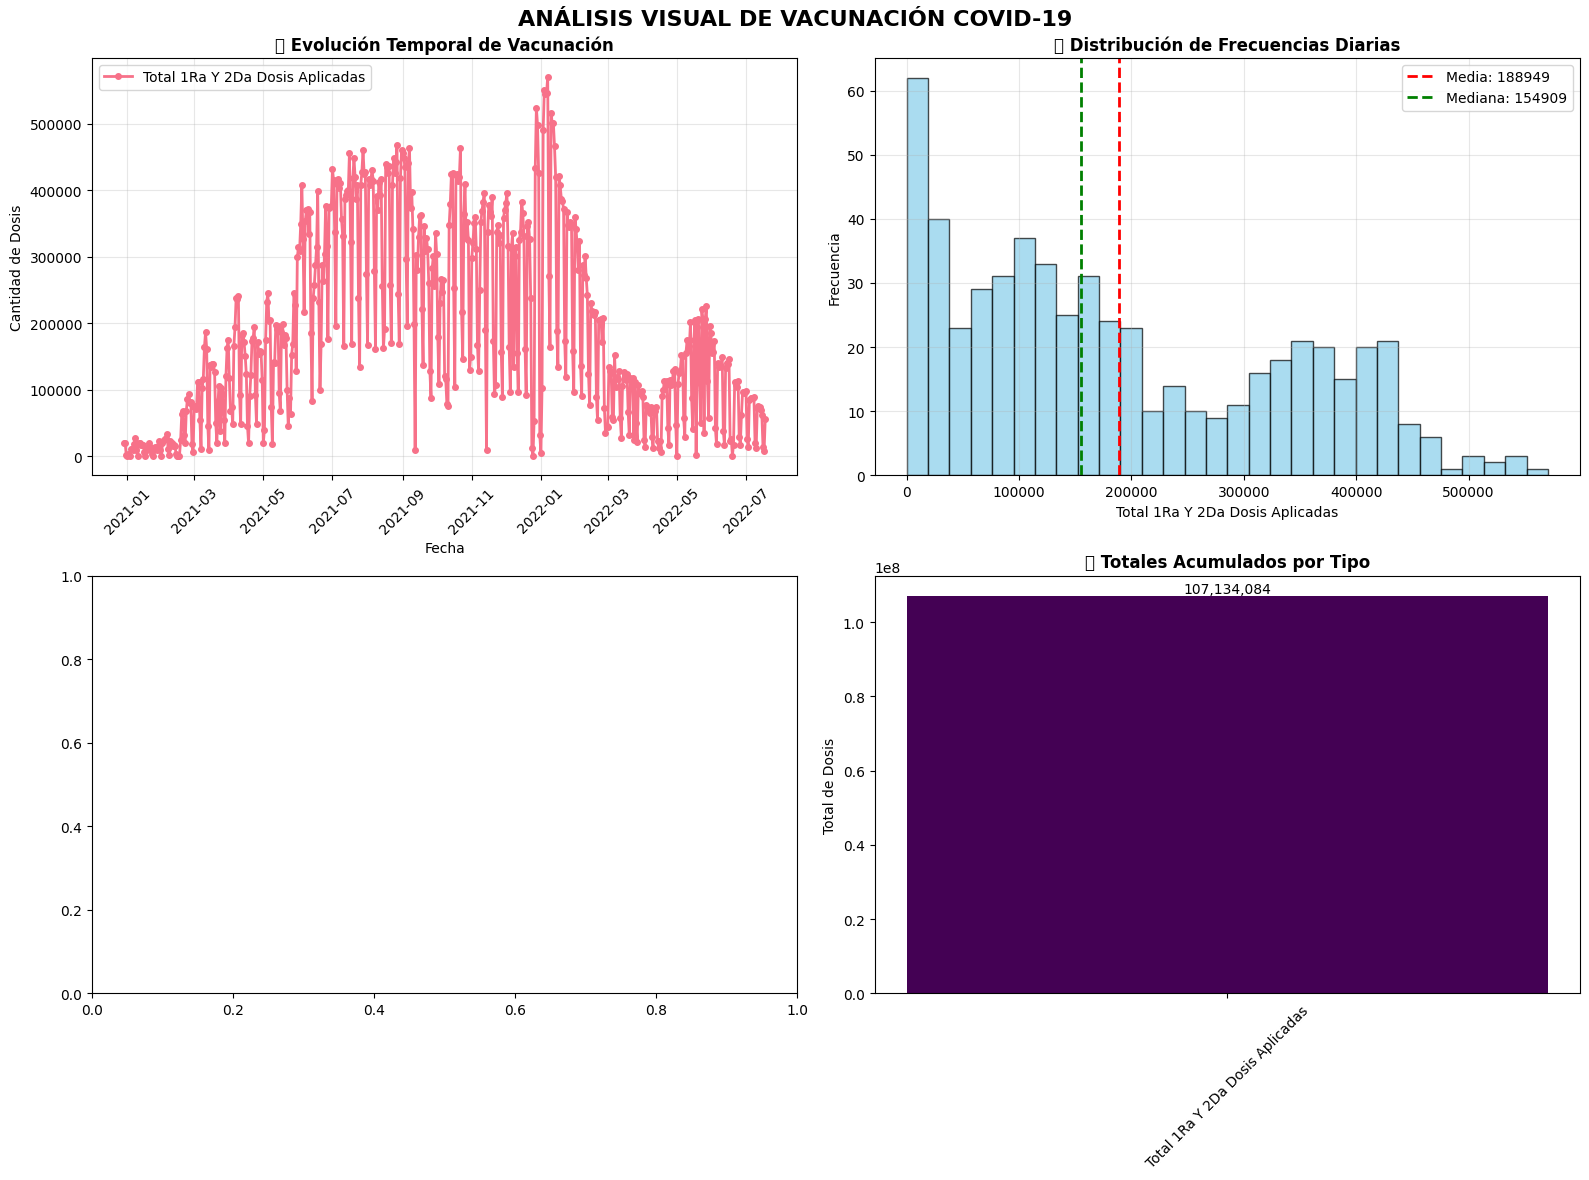


üîç APLICANDO LEY DE BENFORD...

üìä AN√ÅLISIS BENFORD - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   üî¨ Estad√≠stico Chi¬≤: 0.1201
   üìà P-valor: 1.0000
   ‚úÖ Sigue Ley de Benford: S√ç


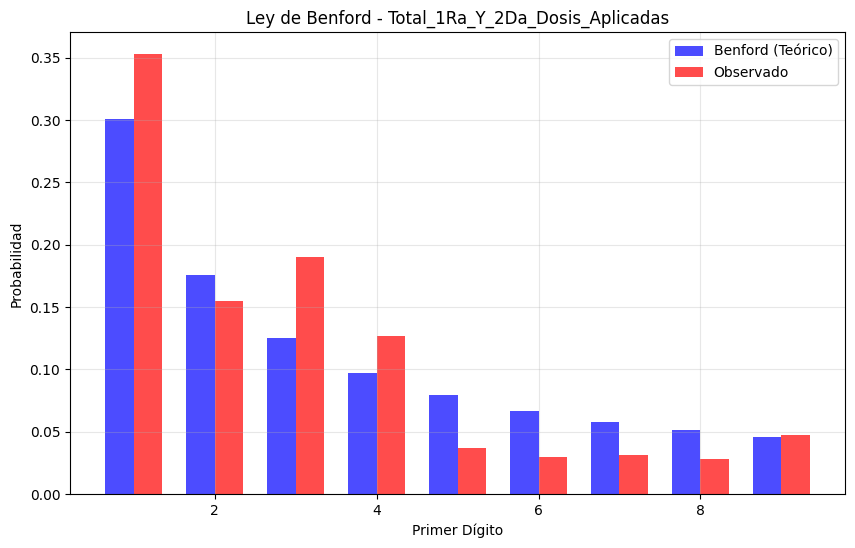


üìä AN√ÅLISIS DE DISTRIBUCIONES ESTAD√çSTICAS...

üî∏ AN√ÅLISIS DE DISTRIBUCI√ìN - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   üìä Test de Normalidad:
      - Estad√≠stico: 105.0625
      - P-valor: 0.0000
      - Es Normal: NO
   üéØ An√°lisis Poisson:
      - Lambda estimado: 188949.0018
      - Podr√≠a ser Poisson: NO

üéØ CALCULANDO PROBABILIDADES CONDICIONALES...

‚úÖ AN√ÅLISIS COMPLETADO EXITOSAMENTE
üìä Todas las tareas han sido ejecutadas
üéØ Conclusiones disponibles en cada secci√≥n


In [ ]:
# ============================================================================
# AN√ÅLISIS COMPLETO DE DATOS DE VACUNACI√ìN COVID-19
# Ciencia de Datos para Obtener Conclusiones Significativas
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import stats
from scipy.stats import normaltest, poisson, binom
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaci√≥n
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("üî¨ AN√ÅLISIS DE DATOS DE VACUNACI√ìN COVID-19")
print("=" * 60)

# ============================================================================
# 1. CARGA Y EXPLORACI√ìN INICIAL DE DATOS
# ============================================================================

def cargar_y_explorar_datos(archivo_path):
    """
    Carga el dataset y realiza exploraci√≥n inicial
    """
    print("\nüìÇ CARGANDO Y EXPLORANDO DATOS...")
    
    # Cargar datos
    df = pd.read_csv(archivo_path)
    
    print(f"‚úÖ Dataset cargado exitosamente")
    print(f"üìä Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"üóÇÔ∏è Columnas disponibles: {list(df.columns)}")
    
    # Informaci√≥n b√°sica del dataset
    print("\nüìã INFORMACI√ìN GENERAL DEL DATASET:")
    print(df.info())
    
    print("\nüëÄ PRIMERAS 5 FILAS:")
    print(df.head())
    
    print("\nüîç VALORES NULOS POR COLUMNA:")
    print(df.isnull().sum())
    
    return df

# ============================================================================
# 2. LIMPIEZA DE DATOS
# ============================================================================

def limpiar_datos(df):
    """
    Limpia y prepara los datos para an√°lisis
    """
    print("\nüßπ INICIANDO LIMPIEZA DE DATOS...")
    df_clean = df.copy()
    
    # 2.1 Identificar columnas num√©ricas que podr√≠an tener formato europeo
    numeric_columns = []
    date_columns = []
    
    for col in df_clean.columns:
        # Identificar columnas de fecha
        if any(word in col.lower() for word in ['fecha', 'date', 'tiempo']):
            date_columns.append(col)
        # Identificar columnas num√©ricas (adaptado para tu dataset espec√≠fico)
        elif any(word in col.lower() for word in ['dosis', 'dose', 'total', 'cantidad', 'num', 'monodosis', 'primera', 'segunda', '1_dosis', '2_dosis']):
            numeric_columns.append(col)
    
    print(f"üìÖ Columnas de fecha identificadas: {date_columns}")
    print(f"üî¢ Columnas num√©ricas identificadas: {numeric_columns}")
    
    # 2.2 Convertir formato europeo a formato est√°ndar
    def convertir_formato_europeo(valor):
        """
        Convierte n√∫meros en formato europeo (1.234,56) a formato est√°ndar (1234.56)
        """
        if pd.isna(valor):
            return np.nan
        
        valor_str = str(valor).strip()
        
        # Si ya es un n√∫mero, devolverlo
        try:
            return float(valor_str)
        except ValueError:
            pass
        
        # Convertir formato europeo
        # Patr√≥n: n√∫meros con puntos como separadores de miles y coma como decimal
        if ',' in valor_str and '.' in valor_str:
            # Formato: 1.234.567,89
            valor_str = valor_str.replace('.', '').replace(',', '.')
        elif ',' in valor_str:
            # Formato: 1234,89
            valor_str = valor_str.replace(',', '.')
        
        try:
            return float(valor_str)
        except ValueError:
            return np.nan
    
    # 2.3 Aplicar conversi√≥n a columnas num√©ricas
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"üîÑ Procesando columna num√©rica: {col}")
            df_clean[col] = df_clean[col].apply(convertir_formato_europeo)
            
            # Convertir a int si todos los valores son enteros
            if df_clean[col].notna().any():
                if df_clean[col].dropna().apply(lambda x: x == int(x)).all():
                    df_clean[col] = df_clean[col].astype('Int64')  # Nullable integer
    
    # 2.4 Convertir columnas de fecha
    for col in date_columns:
        if col in df_clean.columns:
            print(f"üìÖ Procesando columna de fecha: {col}")
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')
                print(f"‚úÖ Fecha convertida exitosamente: {col}")
            except Exception as e:
                print(f"‚ùå Error al convertir fecha {col}: {e}")
    
    # 2.5 Verificar y reportar cambios
    print("\nüìä RESUMEN DE LIMPIEZA:")
    print(f"üî¢ Columnas num√©ricas procesadas: {len(numeric_columns)}")
    print(f"üìÖ Columnas de fecha procesadas: {len(date_columns)}")
    print(f"‚ùå Valores nulos despu√©s de limpieza: {df_clean.isnull().sum().sum()}")
    
    # 2.6 Crear columnas adicionales √∫tiles
    if date_columns:
        fecha_col = date_columns[0]
        if fecha_col in df_clean.columns:
            df_clean['a√±o'] = df_clean[fecha_col].dt.year
            df_clean['mes'] = df_clean[fecha_col].dt.month
            df_clean['dia_semana'] = df_clean[fecha_col].dt.day_name()
            print("‚úÖ Columnas temporales adicionales creadas")
    
    return df_clean, numeric_columns, date_columns

# ============================================================================
# 3. ESTAD√çSTICA DESCRIPTIVA
# ============================================================================

def estadistica_descriptiva(df, numeric_columns):
    """
    Calcula estad√≠sticas descriptivas completas
    """
    print("\nüìà CALCULANDO ESTAD√çSTICA DESCRIPTIVA...")
    
    # 3.1 Estad√≠sticas b√°sicas por columna
    print("\nüìä ESTAD√çSTICAS B√ÅSICAS:")
    for col in numeric_columns:
        if col in df.columns and df[col].notna().any():
            datos = df[col].dropna()
            
            print(f"\nüî∏ {col.upper()}:")
            print(f"   üìè Total: {datos.sum():,.0f}")
            print(f"   üìä Media: {datos.mean():,.2f}")
            print(f"   üìê Mediana: {datos.median():,.2f}")
            print(f"   üìè Desv. Est√°ndar: {datos.std():,.2f}")
            print(f"   ‚¨ÜÔ∏è M√°ximo: {datos.max():,.0f}")
            print(f"   ‚¨áÔ∏è M√≠nimo: {datos.min():,.0f}")
            print(f"   üìà Rango: {datos.max() - datos.min():,.0f}")
            print(f"   üéØ Coef. Variaci√≥n: {(datos.std()/datos.mean())*100:.2f}%")
    
    # 3.2 Tabla resumen
    df_stats = df[numeric_columns].describe()
    print("\nüìã TABLA RESUMEN ESTAD√çSTICO:")
    print(df_stats.round(2))
    
    # 3.3 Matriz de correlaci√≥n
    if len(numeric_columns) > 1:
        print("\nüîó MATRIZ DE CORRELACI√ìN:")
        corr_matrix = df[numeric_columns].corr()
        print(corr_matrix.round(3))
    
    return df_stats

# ============================================================================
# 4. VISUALIZACI√ìN DE DATOS
# ============================================================================

def crear_visualizaciones(df, numeric_columns, date_columns):
    """
    Crea visualizaciones comprehensivas
    """
    print("\nüìä CREANDO VISUALIZACIONES...")
    
    # Configurar subplots
    n_numeric = len(numeric_columns)
    n_plots = min(4, n_numeric + 2)  # M√°ximo 4 gr√°ficos
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('AN√ÅLISIS VISUAL DE VACUNACI√ìN COVID-19', fontsize=16, fontweight='bold')
    
    # 4.1 Gr√°fico de l√≠neas: Evoluci√≥n temporal
    ax1 = axes[0, 0]
    if date_columns and numeric_columns:
        fecha_col = date_columns[0]
        for i, col in enumerate(numeric_columns[:3]):  # M√°ximo 3 series
            if col in df.columns:
                ax1.plot(df[fecha_col], df[col], marker='o', linewidth=2, 
                        markersize=4, label=col.replace('_', ' ').title())
        
        ax1.set_title('üìà Evoluci√≥n Temporal de Vacunaci√≥n', fontweight='bold')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Cantidad de Dosis')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
    
    # 4.2 Histograma: Distribuci√≥n de frecuencias
    ax2 = axes[0, 1]
    if numeric_columns:
        col_principal = numeric_columns[0]
        datos = df[col_principal].dropna()
        
        ax2.hist(datos, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(datos.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {datos.mean():.0f}')
        ax2.axvline(datos.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {datos.median():.0f}')
        
        ax2.set_title('üìä Distribuci√≥n de Frecuencias Diarias', fontweight='bold')
        ax2.set_xlabel(col_principal.replace('_', ' ').title())
        ax2.set_ylabel('Frecuencia')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 4.3 Boxplot: Comparaci√≥n de distribuciones
    ax3 = axes[1, 0]
    if len(numeric_columns) >= 2:
        datos_box = [df[col].dropna() for col in numeric_columns[:4]]
        labels_box = [col.replace('_', ' ').title() for col in numeric_columns[:4]]
        
        ax3.boxplot(datos_box, labels=labels_box)
        ax3.set_title('üì¶ Comparaci√≥n de Distribuciones', fontweight='bold')
        ax3.set_ylabel('Valores')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # 4.4 Gr√°fico de barras: Totales acumulados
    ax4 = axes[1, 1]
    if numeric_columns:
        totales = [df[col].sum() for col in numeric_columns[:5]]
        nombres = [col.replace('_', ' ').title() for col in numeric_columns[:5]]
        
        bars = ax4.bar(nombres, totales, color=plt.cm.viridis(np.linspace(0, 1, len(totales))))
        ax4.set_title('üìä Totales Acumulados por Tipo', fontweight='bold')
        ax4.set_ylabel('Total de Dosis')
        ax4.tick_params(axis='x', rotation=45)
        
        # A√±adir valores en las barras
        for bar, total in zip(bars, totales):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{total:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. LEY DE BENFORD
# ============================================================================

def aplicar_ley_benford(df, numeric_columns):
    """
    Aplica la Ley de Benford para detectar anomal√≠as
    """
    print("\nüîç APLICANDO LEY DE BENFORD...")
    
    # Probabilidades te√≥ricas de Benford
    benford_probs = [np.log10(1 + 1/d) for d in range(1, 10)]
    
    for col in numeric_columns[:2]:  # Analizar las primeras 2 columnas
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos > 0]  # Solo valores positivos
            
            if len(datos) > 0:
                # Extraer primer d√≠gito
                primeros_digitos = []
                for valor in datos:
                    primer_digito = int(str(int(valor))[0])
                    if primer_digito != 0:
                        primeros_digitos.append(primer_digito)
                
                if primeros_digitos:
                    # Calcular frecuencias observadas
                    digitos_unicos, conteos = np.unique(primeros_digitos, return_counts=True)
                    freq_observadas = conteos / len(primeros_digitos)
                    
                    # Crear array completo (d√≠gitos 1-9)
                    freq_completas = np.zeros(9)
                    for i, digito in enumerate(digitos_unicos):
                        if 1 <= digito <= 9:
                            freq_completas[digito-1] = freq_observadas[i]
                    
                    # Test Chi-cuadrado
                    chi2_stat, p_value = stats.chisquare(freq_completas, benford_probs)
                    
                    print(f"\nüìä AN√ÅLISIS BENFORD - {col.upper()}:")
                    print(f"   üî¨ Estad√≠stico Chi¬≤: {chi2_stat:.4f}")
                    print(f"   üìà P-valor: {p_value:.4f}")
                    print(f"   ‚úÖ Sigue Ley de Benford: {'S√ç' if p_value > 0.05 else 'NO'}")
                    
                    # Visualizaci√≥n
                    plt.figure(figsize=(10, 6))
                    x = np.arange(1, 10)
                    width = 0.35
                    
                    plt.bar(x - width/2, benford_probs, width, label='Benford (Te√≥rico)', 
                           alpha=0.7, color='blue')
                    plt.bar(x + width/2, freq_completas, width, label='Observado', 
                           alpha=0.7, color='red')
                    
                    plt.xlabel('Primer D√≠gito')
                    plt.ylabel('Probabilidad')
                    plt.title(f'Ley de Benford - {col.title()}')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()

# ============================================================================
# 6. AN√ÅLISIS DE DISTRIBUCIONES
# ============================================================================

def analizar_distribuciones(df, numeric_columns):
    """
    Verifica si los datos siguen distribuciones conocidas
    """
    print("\nüìä AN√ÅLISIS DE DISTRIBUCIONES ESTAD√çSTICAS...")
    
    for col in numeric_columns[:2]:
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos >= 0]  # Eliminar valores negativos
            
            if len(datos) > 8:  # M√≠nimo para tests estad√≠sticos
                print(f"\nüî∏ AN√ÅLISIS DE DISTRIBUCI√ìN - {col.upper()}:")
                
                # 6.1 Test de Normalidad
                stat_norm, p_norm = normaltest(datos)
                print(f"   üìä Test de Normalidad:")
                print(f"      - Estad√≠stico: {stat_norm:.4f}")
                print(f"      - P-valor: {p_norm:.4f}")
                print(f"      - Es Normal: {'S√ç' if p_norm > 0.05 else 'NO'}")
                
                # 6.2 Test de Poisson
                lambda_est = datos.mean()
                if lambda_est > 0:
                    # Generar distribuci√≥n Poisson te√≥rica
                    poisson_teorica = [poisson.pmf(k, lambda_est) for k in range(int(datos.max())+1)]
                    
                    # Test de bondad de ajuste
                    hist, bins = np.histogram(datos, bins=min(20, int(datos.max())+1))
                    hist_norm = hist / hist.sum()
                    
                    print(f"   üéØ An√°lisis Poisson:")
                    print(f"      - Lambda estimado: {lambda_est:.4f}")
                    print(f"      - Podr√≠a ser Poisson: {'S√ç' if datos.var() / datos.mean() < 2 else 'NO'}")
                
                # 6.3 An√°lisis Binomial (si los datos parecen conteos)
                if datos.max() <= 1000 and datos.min() >= 0:
                    n_est = int(datos.max())
                    p_est = datos.mean() / n_est if n_est > 0 else 0
                    
                    print(f"   üé≤ An√°lisis Binomial:")
                    print(f"      - n estimado: {n_est}")
                    print(f"      - p estimado: {p_est:.4f}")
                    print(f"      - Podr√≠a ser Binomial: {'S√ç' if 0 < p_est < 1 else 'NO'}")

# ============================================================================
# 7. PROBABILIDADES CONDICIONALES
# ============================================================================

def calcular_probabilidades_condicionales(df, numeric_columns):
    """
    Calcula probabilidades condicionales y totales
    Especialmente √∫til para P(2da_dosis | 1era_dosis) y P(monodosis | contexto)
    """
    print("\nüéØ CALCULANDO PROBABILIDADES CONDICIONALES...")
    
    if len(numeric_columns) >= 2:
        # Buscar espec√≠ficamente columnas de 1era y 2da dosis
        primera_dosis_col = None
        segunda_dosis_col = None
        monodosis_col = None
        
        for col in numeric_columns:
            col_lower = col.lower()
            if any(term in col_lower for term in ['primera', '1_dosis', 'first']):
                primera_dosis_col = col
            elif any(term in col_lower for term in ['segunda', '2_dosis', 'second']):
                segunda_dosis_col = col
            elif any(term in col_lower for term in ['monodosis', 'mono']):
                monodosis_col = col
        
        # An√°lisis espec√≠fico para vacunaci√≥n COVID
        if primera_dosis_col and segunda_dosis_col:
            df_prob = df[[primera_dosis_col, segunda_dosis_col]].dropna()
            
            if len(df_prob) > 0:
                print(f"\nüî∏ AN√ÅLISIS: {primera_dosis_col} vs {segunda_dosis_col}")
                
                # Categorizar en Alto/Bajo basado en percentil 75
                p75_1 = df_prob[primera_dosis_col].quantile(0.75)
                p75_2 = df_prob[segunda_dosis_col].quantile(0.75)
                
                df_prob['cat1'] = df_prob[primera_dosis_col].apply(lambda x: 'Alto' if x > p75_1 else 'Bajo')
                df_prob['cat2'] = df_prob[segunda_dosis_col].apply(lambda x: 'Alto' if x > p75_2 else 'Bajo')
                
                # Tabla de contingencia
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\nüìä TABLA DE CONTINGENCIA:")
                print(tabla_contingencia)
                
                # Calcular probabilidades
                total = tabla_contingencia.sum().sum()
                
                # Probabilidades condicionales clave
                if tabla_contingencia.loc['Alto'].sum() > 0:
                    p_segunda_dado_primera = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                    print(f"\nüéØ PROBABILIDAD CLAVE:")
                    print(f"   üìä P(2da Dosis Alta | 1era Dosis Alta) = {p_segunda_dado_primera:.4f}")
                    print(f"   üí° Interpretaci√≥n: Si hay alta aplicaci√≥n de 1era dosis,")
                    print(f"      hay {p_segunda_dado_primera*100:.1f}% probabilidad de alta aplicaci√≥n de 2da dosis")
                
                # An√°lisis de seguimiento (completion rate)
                dias_con_ambas = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] > 0)])
                dias_solo_primera = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] == 0)])
                
                if dias_con_ambas + dias_solo_primera > 0:
                    tasa_seguimiento = dias_con_ambas / (dias_con_ambas + dias_solo_primera)
                    print(f"\nüìà AN√ÅLISIS DE SEGUIMIENTO:")
                    print(f"   - D√≠as con ambas dosis: {dias_con_ambas}")
                    print(f"   - D√≠as solo 1era dosis: {dias_solo_primera}")
                    print(f"   - Tasa de seguimiento: {tasa_seguimiento:.4f} ({tasa_seguimiento*100:.1f}%)")
        
        # Si no encuentra columnas espec√≠ficas, usar an√°lisis general
        else:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_prob = df[[col1, col2]].dropna()
            
            if len(df_prob) > 0:
                # Categorizar en Alto/Bajo basado en mediana
                mediana1 = df_prob[col1].median()
                mediana2 = df_prob[col2].median()
                
                df_prob['cat1'] = df_prob[col1].apply(lambda x: 'Alto' if x > mediana1 else 'Bajo')
                df_prob['cat2'] = df_prob[col2].apply(lambda x: 'Alto' if x > mediana2 else 'Bajo')
                
                # Resto del an√°lisis general...
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\nüìä TABLA DE CONTINGENCIA ({col1} vs {col2}):")
                print(tabla_contingencia)
                
                total = tabla_contingencia.sum().sum()
                p_col1_alto = tabla_contingencia.loc['Alto'].sum() / total
                p_col2_alto = tabla_contingencia['Alto'].sum() / total
                p_col2_dado_col1_alto = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                
                print(f"\nüéØ AN√ÅLISIS DE PROBABILIDADES:")
                print(f"   üìä P({col1} = Alto) = {p_col1_alto:.4f}")
                print(f"   üìä P({col2} = Alto) = {p_col2_alto:.4f}")
                print(f"   üéØ P({col2} = Alto | {col1} = Alto) = {p_col2_dado_col1_alto:.4f}")
        
        # Test de independencia para cualquier caso
        if len(numeric_columns) >= 2:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_test = df[[col1, col2]].dropna()
            if len(df_test) > 0:
                # Crear categor√≠as para test
                df_test['cat1'] = pd.cut(df_test[col1], bins=2, labels=['Bajo', 'Alto'])
                df_test['cat2'] = pd.cut(df_test[col2], bins=2, labels=['Bajo', 'Alto'])
                
                tabla_test = pd.crosstab(df_test['cat1'], df_test['cat2'])
                chi2, p_val, dof, expected = stats.chi2_contingency(tabla_test)
                
                print(f"\nüî¨ TEST DE INDEPENDENCIA:")
                print(f"   - Chi¬≤ = {chi2:.4f}")
                print(f"   - P-valor = {p_val:.4f}")
                print(f"   - Son independientes: {'S√ç' if p_val > 0.05 else 'NO'}")
                print(f"   üí° Las variables {'NO est√°n' if p_val <= 0.05 else 'est√°n'} relacionadas")

# ============================================================================
# 8. FUNCI√ìN PRINCIPAL
# ============================================================================

def main():
    """
    Funci√≥n principal que ejecuta todo el an√°lisis
    """
    # Ruta del archivo - ELIGE UNA DE ESTAS OPCIONES:
    
    # OPCI√ìN 1: Raw string (recomendada)
    archivo_path = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCI√ìN 2: Doble barra invertida
    # archivo_path = "C:\\Users\\Admin\\Desktop\\UNRN\\3ero\\Mate4\\DataSet\\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCI√ìN 3: Barra normal (funciona en Windows tambi√©n)
    # archivo_path = "C:/Users/Admin/Desktop/UNRN/3ero/Mate4/DataSet/total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    try:
        # 1. Cargar y explorar datos
        df_original = cargar_y_explorar_datos(archivo_path)
        
        # 2. Limpiar datos
        df_clean, numeric_columns, date_columns = limpiar_datos(df_original)
        
        # 3. Estad√≠stica descriptiva
        stats_summary = estadistica_descriptiva(df_clean, numeric_columns)
        
        # 4. Visualizaciones
        crear_visualizaciones(df_clean, numeric_columns, date_columns)
        
        # 5. Ley de Benford
        aplicar_ley_benford(df_clean, numeric_columns)
        
        # 6. An√°lisis de distribuciones
        analizar_distribuciones(df_clean, numeric_columns)
        
        # 7. Probabilidades condicionales
        calcular_probabilidades_condicionales(df_clean, numeric_columns)
        
        print("\n" + "="*60)
        print("‚úÖ AN√ÅLISIS COMPLETADO EXITOSAMENTE")
        print("üìä Todas las tareas han sido ejecutadas")
        print("üéØ Conclusiones disponibles en cada secci√≥n")
        print("="*60)
        
        return df_clean
        
    except Exception as e:
        print(f"‚ùå Error durante el an√°lisis: {e}")
        return None

# ============================================================================
# EJECUTAR AN√ÅLISIS
# ============================================================================

if __name__ == "__main__":
    df_resultado = main()